# Data Cleaning
In this notebook, we are going to perform a series of data cleaning step to better assess the quality of the data that we used for our training. 

In [ ]:
! pip install pandas

In [2]:
import pandas as pd
from pathlib import Path
import os
# import
import scipy.io
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os
import scipy.ndimage
from scipy.stats import entropy
log_df = pd.DataFrame(columns=['subj_OG', 'path', 'num_sub_files', 'sub_files', 'site_scanned', 'scanner', 'brain_shape', 'mask_shape', 'mu_shape' 'criteria_1(p/f)', 'criteria_2(p/f)', 'final_decision'])

log_df # display in the notebook 
# now is just an empty table 

,subj_OG,path,num_sub_files,sub_files,site_scanned,scanner,brain_shape,mask_shape,mu_shapecriteria_1(p/f),criteria_2(p/f),final_decision


In [3]:
# import data from the directory 
root_dir = Path("/home/smooi/Desktop/toast/data/toast_pipe_data") # input the correct directory containing all the folders of different subjects
subj_names = [d.name for d in root_dir.iterdir() if d.is_dir() and d.name != "empty_data"]
log_df['subj_OG'] = subj_names

# store the original subject name and their relative path into the pandas df 
log_df['path'] = [os.path.join(root_dir, subj_name) for subj_name in subj_names]
log_df['num_sub_files'] = log_df['path'].apply(lambda path: len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]))
log_df['sub_files'] = log_df['path'].apply(lambda path: [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

# Asssign scanner info according to the subj_OG folder name
def assign_scan_site(subj_names):
    # first allocate the source of the sacnning 
    if subj_names.startswith('Cc'): 
        return "EMORY_PRISMA"
    elif subj_names.startswith('aEA'):
        return "SIEMENS_PRISMA" # from UofDel
    elif subj_names.startswith('2023-U'):
        return "NI_MR4"  # this is GE 
    elif subj_names.startswith('aSTE'):
        return "SIEMENS_PRISMA" # from UofDel
    elif subj_names.startswith('aU01'):
        return "SIEMENS_PRISMA" # from UofDel
    elif subj_names.startswith('MreVol'):
        return "EMORY_PRISMA" # TODO
    elif subj_names.startswith('Nemours'):
        return "unknown" # This is GE , unknown scan site 
    
def assign_scanner(scan_site):
    if scan_site == "EMORY_PRISMA" or scan_site == "CHOA" or scan_site == "ZI_PRISMA" or scan_site == "SIEMENS_PRISMA":
        return "SIEMENS"
    else:
        return "GE"

# now update scan site and scanner (SIMENS OR GE)
log_df['site_scanned'] = log_df['subj_OG'].apply(assign_scan_site) 
log_df['scanner'] = log_df['site_scanned'].apply(assign_scanner)

# We also want to check the original shape of the brain t2bet_norm.nii, mask.mat, and Mu.mat
def get_mat_file_shape(file_path):
    """
    This function will load the mat_file path if the path is valid and return the shape of the mat file.
    """
    if os.path.isfile(file_path):
        mat = scipy.io.loadmat(file_path)
        # print(f"Keys in the .mat file: {mat.keys()}")
        if 'Mu' in mat:
            matrix = mat['Mu']
            return matrix.shape
        elif "t2stack" in mat:
            matrix = mat['t2stack']
            return matrix.shape
        elif "mask" in mat:
            matrix = mat['mask']
            return matrix.shape
        else:
            print("Unknown error occured!")
        
    else:
        print('Unexpected error occured.')
        
# update log_df
# update t2stack.mat
log_df['brain_shape'] = log_df['path'].apply(lambda path: get_mat_file_shape(os.path.join(path, 't2stack.mat')))
log_df['mask_shape'] = log_df['path'].apply(lambda path: get_mat_file_shape(os.path.join(path, 'mask.mat')))
log_df['mu_shape'] = log_df['path'].apply(lambda path: get_mat_file_shape(os.path.join(path, 'Mu.mat')))      

## Data Filtering: Filter out no motion / less Motion Data.
For this criteria, we are going to identify subject with no motion at all, then we will label them as bad data.
The entire brain (Non Nan values are going to count as a whole). 

In [ ]:
# version 1. Using the proportion of stiff data acorss all slices (GLOBAL)

In [3]:
# now, we are going to clean the data according to their quality
# Criteria 1: Filter out no Motion Data
# If the data is No Motion, we will put "F" as fail in criteria 1
# Otherwise, we will put "P" as pass in criteria 2

def criteria_1(stiffness_file_path):
    """
    @ param
    stiffness_file: path to the stiffness matrix whith shape [width, height, slice_number]
    
    return:
    - P/F according to the quality of the stiffness file 

    """
    # load the stiffness file
    stiffness_data = scipy.io.loadmat(stiffness_file_path)
    mu = stiffness_data['Mu']
    # initiate a list to store all the non-Nan values 
    valid_global = []
    for slice_num in range(mu.shape[2]):
        # ignore NaN values and append all valid stiffness dots into the valid_global 
        selected_slice = mu[:,:,slice_num]
        valid_pixels = selected_slice[~np.isnan(selected_slice)]
        if valid_pixels.size == 0:
            continue # skip slices with no valid pixels 
        
        # use extend becau8se we want to flattern the lsit
        valid_global.extend(valid_pixels)

    
    # total = len(valid_global)
    
    valid_global = np.array(valid_global)
    
    # print(f"{stiffness_file_path} : {total}")
    # set threshold
    mu_over = np.sum(valid_global >= 6000)
    mu_under = np.sum(valid_global < 6000)
    total = mu_over + mu_under
    # calculate % of mu_over
    prop = mu_over / total
    # print(f"For subject {stiffness_file_path} : {[prop]}")
    
    if prop >= 0.3:
        print(f"The subject in this directory failed criteria 1: {stiffness_file_path}")
        return "F" # bad data
    else:
        return "P" # good data

# retrieve mu.mat path with concatenating log_df['path'] + Mu.mat
t2bet_path = log_df['path'].apply(lambda x: os.path.join(x, 'Mu.mat'))
pd.set_option('display.max_colwidth', None)
# print(t2bet_path)
log_df['criteria_1(p/f)'] = t2bet_path.apply(criteria_1) 


The subject in this directory failed criteria 1: /home/smooi/Desktop/toast/data/toast_pipe_data/Cc_100FU/Mu.mat
The subject in this directory failed criteria 1: /home/smooi/Desktop/toast/data/toast_pipe_data/Cc_103Post/Mu.mat
The subject in this directory failed criteria 1: /home/smooi/Desktop/toast/data/toast_pipe_data/Cc_108Post/Mu.mat


In [4]:
# Use one individual slices at the mid-slice location to both filter out data with bad motion and less motion 

In [4]:
def criteria_version2(stiffness_file_path):
    """
    @param
    stiffness_file: path to the stiffness matrix with shape [width, height, slice_number]
    
    return:
    - P/F according to the quality of the stiffness file based on the middle slice
    """
    # Load the stiffness file
    stiffness_data = scipy.io.loadmat(stiffness_file_path)
    mu = stiffness_data['Mu']
    
    # Select the middle slice
    middle_slice_index = 25
    middle_slice = mu[:, :, middle_slice_index]
    
    # Ignore NaN values and calculate the proportion of high-stiffness pixels
    valid_pixels = middle_slice[~np.isnan(middle_slice)] # non-empty pixels 
    
    if valid_pixels.size == 0:
        print(f"No valid pixels in the middle slice: {stiffness_file_path}")
        return "F"  # Fail if no valid pixels
    
    # Calculate the proportion of high-stiffness pixels
    mu_over = np.sum(valid_pixels >= 7000)
    total = valid_pixels.size
    prop = mu_over / total
    
    # Check if the proportion exceeds 80%
    if prop >= 0.1:
        print(f"The subject in this directory failed criteria 2: {stiffness_file_path}")
        return "F"  # Bad data
    else:
        return "P"  # Good data

# Retrieve mu.mat path by concatenating log_df['path'] + Mu.mat
t2bet_path = log_df['path'].apply(lambda x: os.path.join(x, 'Mu.mat'))
pd.set_option('display.max_colwidth', None)

# Apply the updated criteria to the log_df
log_df['criteria_2(p/f)'] = t2bet_path.apply(criteria_version2)


The subject in this directory failed criteria 2: /home/smooi/Desktop/toast/data/toast_pipe_data/Cc_100FU/Mu.mat
The subject in this directory failed criteria 2: /home/smooi/Desktop/toast/data/toast_pipe_data/Cc_103Post/Mu.mat


## Change subject folder name 
Naming needs to be easier. For convinient purposes, we are just trying to change all subject folder to [Machine] + "_" + [SubjectID]. In particular, for simplicity purposes, we are just removing all the "_" in the subject ID. 

In [ ]:
# depending on df['scanner'], we are going to append this to the start of every suject name
def update_subj_name(subj_OG, scanner):
    return "S_" + subj_OG if scanner == "SIEMENS" else "G_" + subj_OG


# Create a mapping from original to new names
rename_map = {
    row['subj_OG']: update_subj_name(row['subj_OG'], row['scanner'])
    for _, row in log_df.iterrows()
}

# Rename the folders
for subj_OG, new_name in rename_map.items():
    old_path = os.path.join(root_dir, subj_OG) 
    new_path = os.path.join(root_dir, new_name)
    
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_path} → {new_path}")
    else:
        print(f"Not found: {old_path}")

Renamed: /home/smooi/Desktop/toast/data/toast_pipe_data/aEA_1048A → /home/smooi/Desktop/toast/data/toast_pipe_data/S_aEA_1048A
Renamed: /home/smooi/Desktop/toast/data/toast_pipe_data/aU01_D2002 → /home/smooi/Desktop/toast/data/toast_pipe_data/S_aU01_D2002
Renamed: /home/smooi/Desktop/toast/data/toast_pipe_data/Nemours_0007 → /home/smooi/Desktop/toast/data/toast_pipe_data/G_Nemours_0007
Renamed: /home/smooi/Desktop/toast/data/toast_pipe_data/Nemours_0017 → /home/smooi/Desktop/toast/data/toast_pipe_data/G_Nemours_0017
Renamed: /home/smooi/Desktop/toast/data/toast_pipe_data/aEA_1050A → /home/smooi/Desktop/toast/data/toast_pipe_data/S_aEA_1050A
Renamed: /home/smooi/Desktop/toast/data/toast_pipe_data/2023-U7487-0733-DF → /home/smooi/Desktop/toast/data/toast_pipe_data/G_2023-U7487-0733-DF
Renamed: /home/smooi/Desktop/toast/data/toast_pipe_data/Nemours_0033 → /home/smooi/Desktop/toast/data/toast_pipe_data/G_Nemours_0033
Renamed: /home/smooi/Desktop/toast/data/toast_pipe_data/2023-U7487-00424-

In [ ]:
# visualize pandas dataframe via html
html_file = "toast_data.html"
log_df.to_html(html_file)
print(f"file://{os.path.abspath(html_file)}")

import webbrowser
webbrowser.open(f"file://{os.path.abspath(html_file)}")

## Generate a probability map of stiffness values 
higher values = more trustworthy (likely good)
lower values = suspicious



In [ ]:
! pip install scipy

In [ ]:
import numpy as np
import scipy.io
from scipy.ndimage import binary_dilation, distance_transform_edt
import matplotlib.pyplot as plt

# Load MRE stiffness data
stiff = scipy.io.loadmat("/home/smooi/Desktop/toast/data/toast_pipe_data/aEA_1046/Mu.mat")
stiffness = stiff['Mu']  # shape: (H, W, Slices)
print("Stiffness shape:", stiffness.shape)

threshold = 6000.0
final_prob_maps = []

for slice in range(stiffness.shape[2]):
    slice_data = stiffness[:, :, slice]
    H, W = slice_data.shape

    # Create mask of NaNs
    nan_mask = np.isnan(slice_data)

    # Define edge: 1-pixel ring around NaN
    edge_mask = binary_dilation(nan_mask) & ~nan_mask

    # High-stiffness regions (to penalize if near edge)
    high_stiff_mask = (slice_data >= threshold) & ~nan_mask

    # Compute distance from each pixel to edge (Euclidean)
    dist_to_edge = distance_transform_edt(~edge_mask)  # higher = farther from edge

    # Normalize distances to [0, 1] range
    dist_norm = dist_to_edge / np.max(dist_to_edge)

    # Probability map: default to 1 (fully trusted)
    prob_map = np.ones((H, W))

    # Penalize high-stiffness pixels: closer to edge = lower prob
    prob_map[high_stiff_mask] = dist_norm[high_stiff_mask]  # e.g., 0 near edge, 1 deep inside

    # NaNs always get 0 (common sense)
    prob_map[nan_mask] = 0

    final_prob_maps.append(prob_map)

# Stack slices into 3D volume
final_prob_volume = np.stack(final_prob_maps, axis=-1)


In [ ]:
# plot the final_prob_volume


# Plot all slices in a grid with 4 maps per row
num_slices = final_prob_volume.shape[2]
num_cols = 4
num_rows = (num_slices + num_cols - 1) // num_cols  # Calculate rows needed

plt.figure(figsize=(20, 5 * num_rows))  # Adjust figure size for better visualization

for i in range(num_slices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(final_prob_volume[:, :, i], cmap='hot')
    plt.colorbar()
    plt.title(f'Slice {i}')
    plt.axis('off')  # Turn off axis for cleaner visualization

plt.tight_layout()
plt.show()


In [ ]:
print(final_prob_volume[:, :, 25])

# Export final_prob_volume to .mat file 
output_path = "/home/smooi/Desktop/toast/data/Cc_100FU_final_prob_volume.mat"
# save
scipy.io.savemat(output_path, {'final_prob_volume': final_prob_volume})

In [ ]:
# plot the original stiffness map by slice using for loop
num_slices = stiffness.shape[2]
num_cols = 4
num_rows = (num_slices + num_cols - 1) // num_cols  # Calculate rows needed
plt.figure(figsize=(20, 5 * num_rows))  # Adjust figure size for better visualization
for i in range(num_slices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(stiffness[:, :, i], cmap='hot', vmin=0, vmax=7000)  # Set min and max values
    plt.colorbar()
    plt.title(f'Slice {i}')
    plt.axis('off')  # Turn off axis for cleaner visualization
plt.tight_layout()
plt.show()


In [ ]:
# Let's try a 2 pixel ring 

import numpy as np
import scipy.io
from scipy.ndimage import binary_dilation, distance_transform_edt
import matplotlib.pyplot as plt

# Load MRE stiffness data
stiff = scipy.io.loadmat("/home/smooi/Desktop/toast/data/toast_pipe_data/aEA_1046/Mu.mat")
stiffness = stiff['Mu']  # shape: (H, W, Slices)
print("Stiffness shape:", stiffness.shape)

threshold = 6000.0
final_prob_maps = []

for slice in range(stiffness.shape[2]):
    slice_data = stiffness[:, :, slice]
    H, W = slice_data.shape

    # Create mask of NaNs
    nan_mask = np.isnan(slice_data)

    # Define edge: 4-pixel ring around NaN
    edge_mask_2 = binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(nan_mask)))))))) & ~nan_mask

    # High-stiffness regions (to penalize if near edge)
    high_stiff_mask = (slice_data >= threshold) & ~nan_mask

    # Compute distance from each pixel to edge (Euclidean)
    dist_to_edge = distance_transform_edt(~edge_mask)  # higher = farther from edge

    # Normalize distances to [0, 1] range
    dist_norm = dist_to_edge / np.max(dist_to_edge)

    # Probability map: default to 1 (fully trusted)
    prob_map = np.ones((H, W))

    # Penalize high-stiffness pixels: closer to edge = lower prob
    prob_map[high_stiff_mask] = dist_norm[high_stiff_mask]  # e.g., 0 near edge, 1 deep inside

    # NaNs always get 0 (common sense)
    prob_map[nan_mask] = 0

    final_prob_maps.append(prob_map)

# Stack slices into 3D volume
final_prob_volume = np.stack(final_prob_maps, axis=-1)



In [ ]:
# plot the final_prob_volume


# Plot all slices in a grid with 4 maps per row
num_slices = final_prob_volume.shape[2]
num_cols = 4
num_rows = (num_slices + num_cols - 1) // num_cols  # Calculate rows needed

plt.figure(figsize=(20, 5 * num_rows))  # Adjust figure size for better visualization

for i in range(num_slices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(final_prob_volume[:, :, i], cmap='hot')
    plt.colorbar()
    plt.title(f'Slice {i}')
    plt.axis('off')  # Turn off axis for cleaner visualization

plt.tight_layout()
plt.show()


## Smooth the probability map

In [ ]:
# Let's try a 2 pixel ring 

import numpy as np
import scipy.io
from scipy.ndimage import binary_dilation, distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Load MRE stiffness data
stiff = scipy.io.loadmat("/home/smooi/Desktop/toast/data/toast_pipe_data/aEA_1046/Mu.mat")
stiffness = stiff['Mu']  # shape: (H, W, Slices)
print("Stiffness shape:", stiffness.shape)

threshold = 6000.0
final_prob_maps = []

for slice in range(stiffness.shape[2]):
    slice_data = stiffness[:, :, slice]
    H, W = slice_data.shape

    # Create mask of NaNs
    nan_mask = np.isnan(slice_data)

    # Define edge: 4-pixel ring around NaN
    edge_mask_2 = binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(nan_mask)))))))) & ~nan_mask

    # High-stiffness regions (to penalize if near edge)
    high_stiff_mask = (slice_data >= threshold) & ~nan_mask

    # Compute distance from each pixel to edge (Euclidean)
    dist_to_edge = distance_transform_edt(~edge_mask_2)  # higher = farther from edge

    # Normalize distances to [0, 1] range
    dist_norm = dist_to_edge / np.max(dist_to_edge)

    # Probability map: default to 1 (fully trusted)
    prob_map = np.ones((H, W))

    # Penalize high-stiffness pixels: closer to edge = lower prob
    prob_map[high_stiff_mask] = dist_norm[high_stiff_mask]  # e.g., 0 near edge, 1 deep inside

    # NaNs always get 0 (common sense)
    prob_map[nan_mask] = 0
    
    prob_map = gaussian_filter(prob_map, sigma=1) # gentle smoothing 
    
    
    # TODO: decide if we want to keep hard zeros at NaN locations
    final_prob_maps.append(prob_map)

# Stack slices into 3D volume
final_prob_volume = np.stack(final_prob_maps, axis=-1)



Stiffness shape: (160, 160, 80)


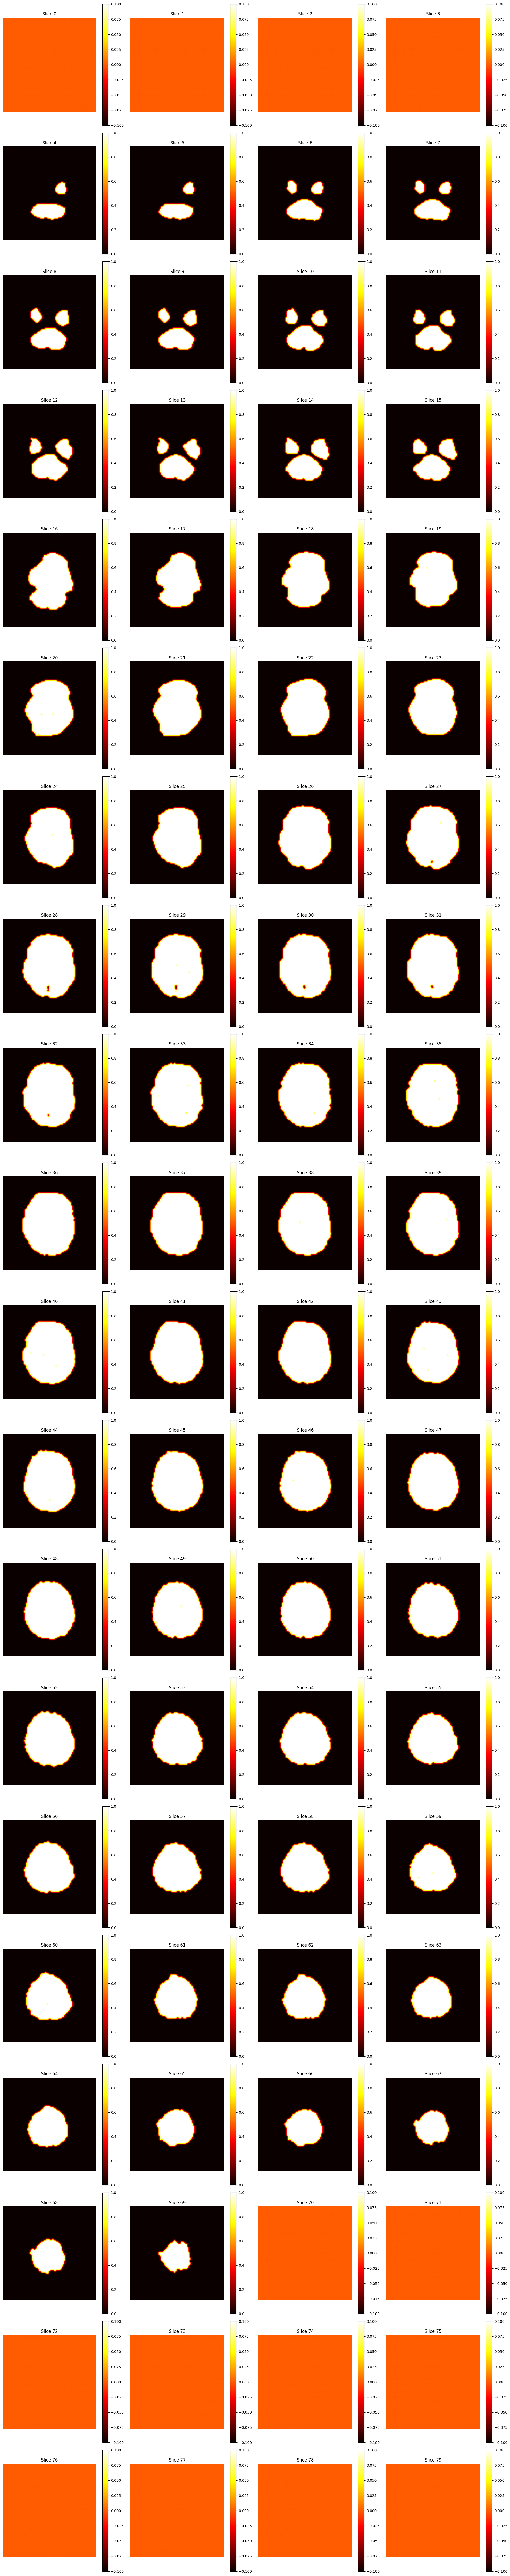

In [3]:
# plot the final_prob_volume


# Plot all slices in a grid with 4 maps per row
num_slices = final_prob_volume.shape[2]
num_cols = 4
num_rows = (num_slices + num_cols - 1) // num_cols  # Calculate rows needed

plt.figure(figsize=(20, 5 * num_rows))  # Adjust figure size for better visualization

for i in range(num_slices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(final_prob_volume[:, :, i], cmap='hot')
    plt.colorbar()
    plt.title(f'Slice {i}')
    plt.axis('off')  # Turn off axis for cleaner visualization

plt.tight_layout()
plt.show()
